# Getting the Training Data

Let's get the training data for the Siamese Network algorithm.

In [137]:
import glob
import jams
import librosa
import matplotlib.pyplot as plt
import msaf
import numpy as np
import os
import pickle

%matplotlib inline

AVG_SIZE = 495  # Average upper SALAMI segment length
SILENCE = -80   # Silence in the current CQT representation
CQT_BINS = 84   # Number of frequency CQT bins
SR = 22050      # Sampling rate
HOP_LEN = 1024  # Hop Size

In [133]:
file_struct = msaf.input_output.FileStruct("/home/uri/datasets/SALAMI/audio/995.mp3")
feats = msaf.features.CQT(file_struct, msaf.base.FeatureTypes.framesync, n_bins=CQT_BINS,
                          hop_length=HOP_LEN, sr=SR)
F = feats.features
references = msaf.io.read_references(file_struct.audio_file, annotator_id=0)
references

(array([  0.00000000e+00,   4.89800000e-02,   5.27093000e+00,
          7.24888900e+00,   3.19290700e+01,   5.73226760e+01,
          9.57453740e+01,   1.20974807e+02,   1.46457959e+02,
          1.95950317e+02,   1.97926893e+02,   2.00238481e+02,
          2.16947506e+02,   2.25239433e+02,   2.42131156e+02,
          2.50365238e+02,   2.67178322e+02,   2.75501565e+02,
          2.92283696e+02,   3.00739841e+02,   3.17527551e+02,
          3.25849592e+02,   3.42673878e+02,   3.58643991e+02,
          3.90836145e+02,   4.22908980e+02,   4.39551769e+02,
          4.47452698e+02,   4.77178639e+02,   4.85038050e+02,
          5.17312766e+02,   5.66975782e+02,   5.83703220e+02,
          5.86522449e+02,   5.86710204e+02]),
 ['silence',
  'no_function',
  'intro',
  'instrumental',
  'verse',
  'chorus',
  'instrumental',
  'verse',
  'chorus',
  'no_function',
  'intro',
  'interlude',
  'verse',
  'chorus',
  'verse',
  'chorus',
  'verse',
  'chorus',
  'instrumental',
  'instrumental',
 

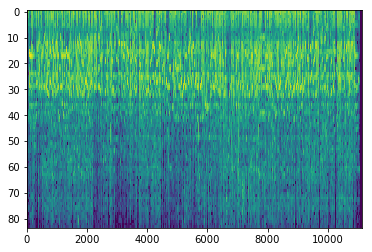

In [43]:
plt.imshow(F.T, interpolation="nearest", aspect="auto", cmap="viridis")

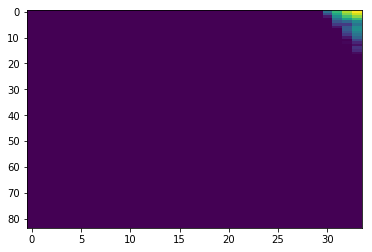

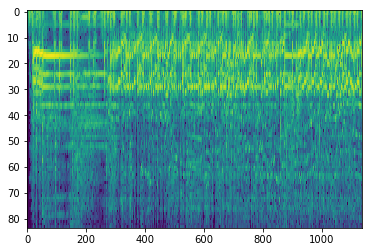

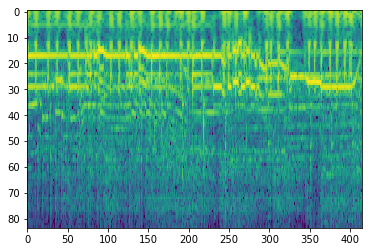

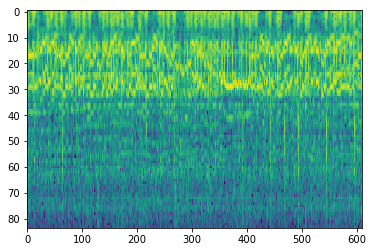

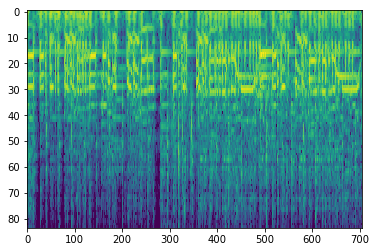

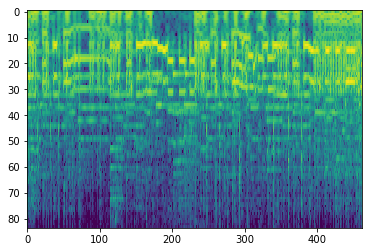

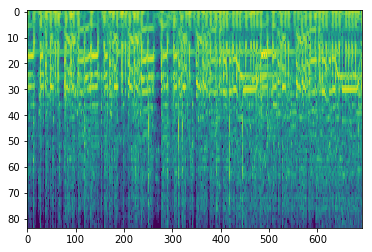

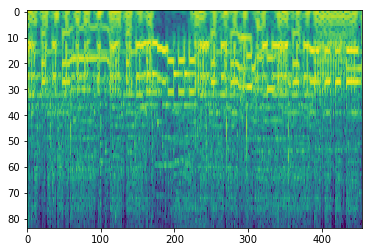

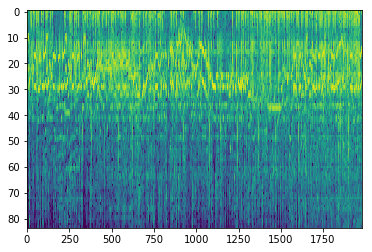

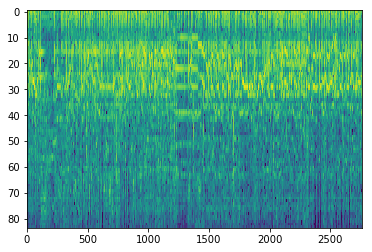

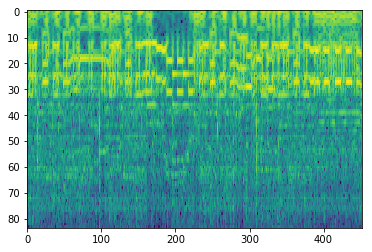

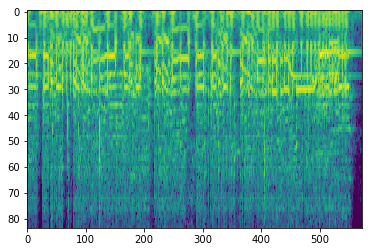

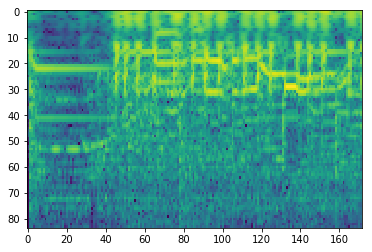

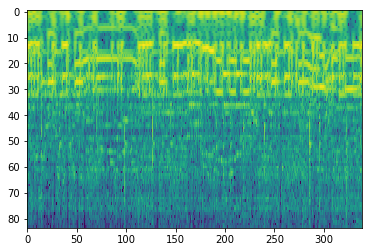

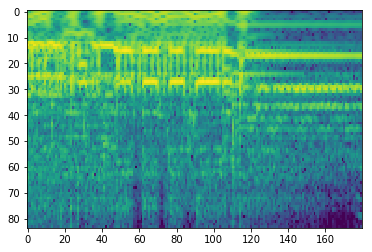

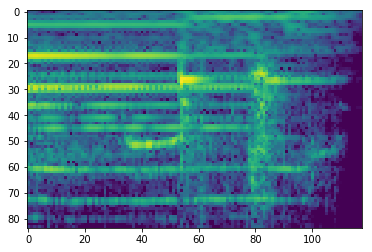

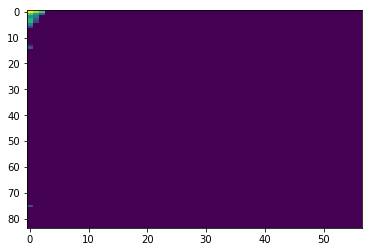

In [42]:
bounds = librosa.time_to_frames(references[0], sr=feats.sr, hop_length=feats.hop_length)
for interval in msaf.utils.times_to_intervals(bounds):
    plt.figure()
    plt.imshow(F[interval[0]:interval[1]].T, interpolation="nearest", aspect="auto", cmap="viridis")

# Average SALAMI Upper Segment Length

Let's compute the average segment length for all `function` and `upper` annotations in SALAMI. This will guide us to decide on the length of the training data.

Average: 22.97 seconds $\approx$ 495 frames

In [69]:
# Compute average segment length
jams_files = glob.glob("/home/uri/datasets/SALAMI/references/*.jams")
inter_times = []
for jams_file in jams_files:
    for ann in jams.load(jams_file).annotations:
        if ann.namespace == "segment_salami_function" or ann.namespace == "segment_salami_upper":
            inters, _ = ann.data.to_interval_values()
            inter_times += [inter[1] - inter[0] for inter in inters]
np.mean(inter_times)

22.97404575080899

In [72]:
# Get number of frames
np.mean(inter_times) * feats.sr / feats.hop_length

494.70479375521313

# Get Segment Patches

Actual training data

In [ ]:
def get_patches(F, inters, n_frames=AVG_SIZE, n_bins=CQT_BINS, silence=SILENCE):
    """Zeropads / crops the segments to obtain the patches."""
    patches = np.ones((len(inters), n_frames, n_bins)) * silence
    for i, inter in enumerate(inters):
        frame1 = librosa.time_to_frames(inter[0], sr=SR, hop_length=HOP_LEN)[0]
        frame2 = librosa.time_to_frames(inter[1], sr=SR, hop_length=HOP_LEN)[0]
        if frame2 > F.shape[0]:
            frame2 = F.shape[0]
        seg_len = frame2 - frame1
        if seg_len < n_frames:
            # Put in middle and zero pad
            start = int(n_frames / 2) - int(seg_len / 2)
            patches[i, start:start + seg_len] = F[frame1:frame2]
        else:
            # Crop segment
            start = int(seg_len / 2) - int(n_frames / 2)
            patches[i] = F[start:start + n_frames]
    return patches


def get_pairwise_data(patches, labels):
    y = []
    x1 = []
    x2 = []
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            x1.append(patches[i])
            x2.append(patches[j])
            y.append(int(label1 == label2))
    return np.asarray(x1), np.asarray(x2), np.asarray(y, dtype=np.int)
            

out_dir = "../train_data"
mp3_files = glob.glob("/home/uri/datasets/SALAMI/audio/*.mp3")
for i, mp3_file in enumerate(mp3_files):
    if i % 10 == 0: 
        print("\t{} of {}".format(i, len(mp3_files)))
        
    file_struct = msaf.input_output.FileStruct(mp3_file)
    feats = msaf.features.CQT(file_struct, msaf.base.FeatureTypes.framesync, n_bins=CQT_BINS,
                              hop_length=HOP_LEN, sr=SR)
    F = feats.features
    try:
        k = 0
        x1 = x2 = y = []
        for ann in jams.load(file_struct.ref_file).annotations:
            if ann.namespace == "segment_salami_function" or ann.namespace == "segment_salami_upper":
                inters, labels = ann.data.to_interval_values()
                patches = get_patches(F, inters)
                tx1, tx2, ty = get_pairwise_data(patches, labels)
                if k == 0:
                    x1, x2, y = tx1, tx2, ty
                else:
                    x1 = np.concatenate((x1, tx1))
                    x2 = np.concatenate((x2, tx2))
                    y = np.concatenate((y, ty))
                k += 1
        if len(x1) != 0:
            out_file = os.path.join(out_dir, os.path.basename(mp3_file).strip(".mp3") + ".pk")
            pickle.dump((x1, x2, y), open(out_file, "wb"))
    except IOError:
        continue

	0 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)


	10 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	20 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	30 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	40 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	50 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	60 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	70 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	80 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	90 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	100 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	110 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	120 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	130 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	140 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	150 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	160 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	170 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	180 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	190 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	200 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	210 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	220 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	230 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	240 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	250 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	260 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	270 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	280 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	290 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	300 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	310 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	320 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	330 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	340 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	350 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	360 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	370 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	380 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	390 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	400 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	410 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	420 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	430 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	440 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	450 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	460 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	470 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	480 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	490 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	500 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	510 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	520 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	530 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	540 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	550 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	560 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	570 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	580 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	590 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	600 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	610 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	620 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	630 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	640 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	650 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	660 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	670 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	680 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	690 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	700 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	710 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	720 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	730 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	740 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	750 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	760 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	770 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	780 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	790 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	800 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	810 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	820 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	830 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	840 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	850 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	860 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	870 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	880 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	890 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	900 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	910 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	920 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	930 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	940 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	950 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	960 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	970 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	980 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	990 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	1000 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	1010 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	1020 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	1030 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: Deprecati

	1040 of 1446


/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)
/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)


In [127]:
print(len(X), len(patches), labels)
print(np.asarray([x[2] for x in X]).reshape((int(np.sqrt(len(X))), int(np.sqrt(len(X))))))

256 16 ['Silence', 'Z', 'A', 'B', 'B', 'C', 'A', 'B', 'B', 'C', 'A', 'B', 'B', 'C', 'Z', 'Silence']
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
